In [ ]:
import os
import glob
import pandas as pd

def read_data(base_wd):
    data_dict = {}
    for file in glob.glob(os.path.join(base_wd, '*.csv')):
        name = os.path.basename(file).replace('.csv', '')
        df = pd.read_csv(file)
        data_dict[name] = df
    return data_dict

base_wd = r"D:\myx\Data science project·\anonymisedData"
data_dict = read_data(base_wd)

print(data_dict.keys())

dict_keys(['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle'])


In [3]:
def raw_data_eda(data_dict):
    for name, df in data_dict.items():
        print(f"{name}: {df.shape[0]} rows × {df.shape[1]} columns")
        print(f"Missing values:\n{df.isnull().sum()}\n")

raw_data_eda(data_dict)


assessments: 206 rows × 6 columns
Missing values:
code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

courses: 22 rows × 3 columns
Missing values:
code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

studentAssessment: 173912 rows × 5 columns
Missing values:
id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

studentInfo: 32593 rows × 12 columns
Missing values:
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

studentRegistration: 32593 rows × 5 col

In [ ]:


def prep_vle_data(df):
    
    keys = ['code_module', 'code_presentation', 'id_student', 'activity_type']
    keys_no_activity = ['code_module', 'code_presentation', 'id_student']

    n_days = df.groupby(keys)['date'].nunique().reset_index().rename(columns={'date': 'n_days'})
    
    sum_clicks = df.groupby(keys)['sum_click'].sum().reset_index().rename(columns={'sum_click': 'sum_clicks'})

    vle_df = pd.merge(n_days, sum_clicks, on=keys, how='inner')

    vle_pivot = vle_df.pivot_table(index=keys_no_activity,
                                   columns='activity_type',
                                   values=['n_days', 'sum_clicks'],
                                   fill_value=0)

    vle_pivot.columns = [f'{i}_{j}' for i, j in vle_pivot.columns]
    vle_pivot = vle_pivot.reset_index()

    vle_pivot['total_n_days'] = vle_pivot[[c for c in vle_pivot.columns if c.startswith('n_days_')]].sum(axis=1)
    vle_pivot['total_sum_clicks'] = vle_pivot[[c for c in vle_pivot.columns if c.startswith('sum_clicks_')]].sum(axis=1)

    return vle_pivot



def get_master_df_rq1(data_dict):
    """
    Merge relevant dataframes and fields from raw data to create master dataframes
    """
    df1 = data_dict['studentInfo']
    df2 = data_dict['studentVle']
    df3 = data_dict['studentAssessment']
    df4 = data_dict['studentRegistration']
    df5 = data_dict['assessments']
    df6 = data_dict['vle']
    df_courses = data_dict['courses']

    keys = ['code_module', 'code_presentation', 'id_student', 'id_assessment', 'id_site']

    df1 = df1[['code_module', 'code_presentation', 'id_student',
               'gender', 'highest_education',
               'imd_band', 'age_band', 'final_result','region','disability']]

    rq1_df = df1.merge(df4, on=keys[0:3], how='inner')

    df2 = df2.merge(
        df_courses[['code_module', 'code_presentation', 'module_presentation_length']],
        on=['code_module', 'code_presentation'], how='left'
    )
    df2 = df2[df2['date'] <= df2['module_presentation_length'] * 0.25]
 
    student_vle = df2.merge(df6, on=['code_module', 'code_presentation', 'id_site'], how='inner')\
        .drop(['week_from', 'week_to'], axis=1)

    rq1_vle_final = prep_vle_data(student_vle)

    rq1_df = rq1_df.merge(rq1_vle_final, on=keys[0:3], how='inner')

    module_len = df2[['code_module', 'code_presentation', 'id_student', 'module_presentation_length']].drop_duplicates()
    rq1_df = rq1_df.merge(module_len, on=['code_module', 'code_presentation', 'id_student'], how='left')

    rq1_df['cutoff_day'] = rq1_df['module_presentation_length'] * 0.25

    rq1_df = rq1_df[(rq1_df['date_unregistration'].isna()) |
                    (rq1_df['date_unregistration'] > rq1_df['cutoff_day'])]


    return rq1_df

In [60]:

rq1_df = get_master_df_rq1(data_dict)

rq1_df.head()


,code_module,code_presentation,id_student,gender,highest_education,imd_band,age_band,final_result,region,disability,...,sum_clicks_questionnaire,sum_clicks_quiz,sum_clicks_resource,sum_clicks_sharedsubpage,sum_clicks_subpage,sum_clicks_url,total_n_days,total_sum_clicks,module_presentation_length,cutoff_day
0,AAA,2013J,11391,M,HE Qualification,90-100%,55<=,Pass,East Anglian Region,N,...,0.0,0.0,3.0,0.0,11.0,0.0,8.0,147.0,268,0.0
1,AAA,2013J,28400,F,HE Qualification,20-30%,35-55,Pass,Scotland,N,...,0.0,0.0,5.0,0.0,26.0,10.0,32.0,263.0,268,0.0
2,AAA,2013J,30268,F,A Level or Equivalent,30-40%,35-55,Withdrawn,North Western Region,Y,...,0.0,0.0,4.0,0.0,12.0,1.0,19.0,102.0,268,0.0
3,AAA,2013J,31604,F,A Level or Equivalent,50-60%,35-55,Pass,South East Region,N,...,0.0,0.0,9.0,0.0,19.0,3.0,22.0,169.0,268,0.0
4,AAA,2013J,32885,F,Lower Than A Level,50-60%,0-35,Pass,West Midlands Region,N,...,0.0,0.0,7.0,0.0,17.0,3.0,33.0,295.0,268,0.0


In [ ]:


df_assessments = data_dict['assessments']             
df_studentAssessment = data_dict['studentAssessment'] 
df_courses = data_dict['courses']                 


df = df_studentAssessment.merge(df_assessments, on='id_assessment', how='inner')
df = df.merge(df_courses, on=['code_module', 'code_presentation'], how='inner')

df['day_percent'] = df['module_presentation_length'] * 0.25

# Keep records completed within the first 25% of the course duration  
df_early = df[df['date'] <= df['day_percent']]

# Aggregate by student to calculate the mean and standard deviation  
# score_stats = df_early.groupby(['code_module', 'code_presentation', 'id_student'])['score'] \
#                           .agg(early_score_mean='mean', early_score_std='std') \
#                           .reset_index()

score_stats = df_early.groupby(['code_module', 'code_presentation', 'id_student'])['score'] \
                      .agg(early_score_mean='mean') \
                      .reset_index()

# Merge the results into the final student dataframe
rq1_df1 = rq1_df.merge(score_stats, on=['code_module', 'code_presentation', 'id_student'], how='inner')
rq1_df1.head()


,code_module,code_presentation,id_student,gender,highest_education,imd_band,age_band,final_result,region,disability,...,sum_clicks_quiz,sum_clicks_resource,sum_clicks_sharedsubpage,sum_clicks_subpage,sum_clicks_url,total_n_days,total_sum_clicks,module_presentation_length,cutoff_day,early_score_mean
0,AAA,2013J,11391,M,HE Qualification,90-100%,55<=,Pass,East Anglian Region,N,...,0.0,3.0,0.0,11.0,0.0,8.0,147.0,268,0.0,78.0
1,AAA,2013J,28400,F,HE Qualification,20-30%,35-55,Pass,Scotland,N,...,0.0,5.0,0.0,26.0,10.0,32.0,263.0,268,0.0,70.0
2,AAA,2013J,31604,F,A Level or Equivalent,50-60%,35-55,Pass,South East Region,N,...,0.0,9.0,0.0,19.0,3.0,22.0,169.0,268,0.0,72.0
3,AAA,2013J,32885,F,Lower Than A Level,50-60%,0-35,Pass,West Midlands Region,N,...,0.0,7.0,0.0,17.0,3.0,33.0,295.0,268,0.0,69.0
4,AAA,2013J,38053,M,A Level or Equivalent,80-90%,35-55,Pass,Wales,N,...,0.0,6.0,0.0,15.0,1.0,34.0,325.0,268,0.0,79.0


In [ ]:
rq1_df1.to_csv(r'D:\myx\Data science project·\rq1_df1_0.25.csv', index=False, encoding='utf-8')

In [ ]:

print("All variables：")
print(rq1_df1.columns.tolist())
print(f"Number of students：{rq1_df1['id_student'].nunique()}")

print(rq1_df1['final_result'].value_counts())

print(rq1_df1['gender'].value_counts())

print(rq1_df1['highest_education'].value_counts())

print(rq1_df1['imd_band'].value_counts())

print(rq1_df1['age_band'].value_counts())


All variables：
['code_module', 'code_presentation', 'id_student', 'gender', 'highest_education', 'imd_band', 'age_band', 'final_result', 'region', 'disability', 'date_registration', 'date_unregistration', 'n_days_dataplus', 'n_days_dualpane', 'n_days_externalquiz', 'n_days_forumng', 'n_days_glossary', 'n_days_homepage', 'n_days_htmlactivity', 'n_days_oucollaborate', 'n_days_oucontent', 'n_days_ouelluminate', 'n_days_ouwiki', 'n_days_page', 'n_days_questionnaire', 'n_days_quiz', 'n_days_resource', 'n_days_sharedsubpage', 'n_days_subpage', 'n_days_url', 'sum_clicks_dataplus', 'sum_clicks_dualpane', 'sum_clicks_externalquiz', 'sum_clicks_forumng', 'sum_clicks_glossary', 'sum_clicks_homepage', 'sum_clicks_htmlactivity', 'sum_clicks_oucollaborate', 'sum_clicks_oucontent', 'sum_clicks_ouelluminate', 'sum_clicks_ouwiki', 'sum_clicks_page', 'sum_clicks_questionnaire', 'sum_clicks_quiz', 'sum_clicks_resource', 'sum_clicks_sharedsubpage', 'sum_clicks_subpage', 'sum_clicks_url', 'total_n_days', '

In [ ]:
# early_score_mean , early_score_std
print("\nearly_score_mean:")
print(rq1_df1['early_score_mean'].describe())
missing_counts = rq1_df1.isnull().sum()
print(missing_counts[missing_counts > 0])


early_score_mean:
count    17454.000000
mean        72.904320
std         21.756625
min          0.000000
25%         65.000000
50%         78.000000
75%         88.000000
max        100.000000
Name: early_score_mean, dtype: float64
imd_band                 768
date_registration          2
date_unregistration    14098
early_score_mean          14
dtype: int64


In [ ]:

module_dfs = {module: df for module, df in rq1_df1.groupby('code_module')}
module_dfs['AAA'] 

,code_module,code_presentation,id_student,gender,highest_education,imd_band,age_band,final_result,region,disability,...,sum_clicks_quiz,sum_clicks_resource,sum_clicks_sharedsubpage,sum_clicks_subpage,sum_clicks_url,total_n_days,total_sum_clicks,module_presentation_length,cutoff_day,early_score_mean
0,AAA,2013J,11391,M,HE Qualification,90-100%,55<=,Pass,East Anglian Region,N,...,0.0,3.0,0.0,11.0,0.0,8.0,147.0,268,0.0,78.0
1,AAA,2013J,28400,F,HE Qualification,20-30%,35-55,Pass,Scotland,N,...,0.0,5.0,0.0,26.0,10.0,32.0,263.0,268,0.0,70.0
2,AAA,2013J,31604,F,A Level or Equivalent,50-60%,35-55,Pass,South East Region,N,...,0.0,9.0,0.0,19.0,3.0,22.0,169.0,268,0.0,72.0
3,AAA,2013J,32885,F,Lower Than A Level,50-60%,0-35,Pass,West Midlands Region,N,...,0.0,7.0,0.0,17.0,3.0,33.0,295.0,268,0.0,69.0
4,AAA,2013J,38053,M,A Level or Equivalent,80-90%,35-55,Pass,Wales,N,...,0.0,6.0,0.0,15.0,1.0,34.0,325.0,268,0.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,AAA,2014J,2677624,M,A Level or Equivalent,10-20,35-55,Pass,North Western Region,N,...,0.0,6.0,0.0,25.0,1.0,27.0,193.0,269,0.0,70.0
656,AAA,2014J,2680312,M,HE Qualification,90-100%,55<=,Pass,Scotland,N,...,0.0,4.0,0.0,11.0,3.0,15.0,202.0,269,0.0,76.0
657,AAA,2014J,2690062,F,A Level or Equivalent,90-100%,35-55,Withdrawn,North Western Region,N,...,0.0,0.0,0.0,2.0,0.0,8.0,27.0,269,0.0,58.0
658,AAA,2014J,2692514,M,Lower Than A Level,0-10%,35-55,Pass,North Western Region,N,...,0.0,7.0,0.0,30.0,0.0,74.0,859.0,269,0.0,75.0


In [ ]:


def feature_eng_clean(df, base_wd, name):
    df['year'] = df['code_presentation'].str.strip().str[0:4]
    df['semester'] = df['code_presentation'].str.strip().str[-1]
    df2 = df.copy(deep=True)

    le_cols = ['final_result', 'age_band', 'imd_band', 'disability', 'gender',
               'region', 'highest_education', 'code_module', 'semester']

    custom_maps = {
        'final_result': {
            'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3
        },
        'highest_education': {
            'No Formal quals': 0,
            'Lower Than A Level': 1,
            'A Level or Equivalent': 2,
            'HE Qualification': 3,
            'Post Graduate Qualification': 4
        }
    }

    for col in le_cols:
        if col in df2.columns:
            if col in custom_maps:
                df2[col] = df2[col].map(custom_maps[col])
                print(f"Custom encoding for '{col}': {custom_maps[col]}")
            else:
                label_encoder = preprocessing.LabelEncoder()
                df2[col] = label_encoder.fit_transform(df2[col])
                print(f"Auto encoding for column '{col}':")
                for i, class_name in enumerate(label_encoder.classes_):
                    print(f"  {i} -> {class_name}")

    # create overall total clicks column
    # df2['overall_total_clicks'] = df2['total_n_days'] * df2['avg_total_sum_clicks']

    return df2


def cap_outliers(col):

    col_capped = col.clip(upper=col.quantile(0.98))

    return col_capped


def outlier_boxplt(df, name, base_wd):

    plt.clf()
    fig_outliers = sns.boxplot(x='variable', y='value', data=pd.melt(df))
    fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
    plt.tight_layout()
    fig_outliers.figure.savefig(base_wd + '\\outputs\\plots\\cleaning\\' + name + '_outlier_boxplots.png')


def basic_clean(df, base_wd, name):

    # missingness

    nulls = df.isnull().sum()
    drop_cols = []

    for i, v in nulls.items():
        if v == len(df):
            drop_cols.append(i)

    df = df.drop(columns=drop_cols)

    # drop missing records for non-numeric columns
    df = df.dropna(axis=0, subset=['imd_band', 'early_score_mean'])

    # imputations
    df = df.fillna(0)
    

    prefixes = ['n_day', 'sum_clicks']
    num_vars = list(compress(df.columns, df.columns.str.startswith(tuple(prefixes))))

    outlier_boxplt(df[num_vars], name, base_wd)

    

    for col in num_vars:
        if col != 'score':
            df[col] = cap_outliers(df[col])

    outlier_boxplt(df[num_vars], name + '_capped', base_wd)

    return df, num_vars


def clean_data(df):
    base_wd = os.path.normpath(os.getcwd()) 

    plot_dir = os.path.join(base_wd, 'outputs', 'plots', 'cleaning')
    data_dir = os.path.join(base_wd, 'outputs', 'dataframes')
    
    os.makedirs(plot_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)

    df2, num_vars = basic_clean(df, base_wd, df.name)
    df_cleaned = feature_eng_clean(df2, base_wd, df.name)

    # save cleaned df
    df_cleaned.to_csv(base_wd + f'\\outputs\\dataframes\\' + df.name + '_cleaned_0.25.csv')

    return df_cleaned, df2

Cleaning course AAA...


C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)


Custom encoding for 'final_result': {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}
Auto encoding for column 'age_band':
  0 -> 0-35
  1 -> 35-55
  2 -> 55<=
Auto encoding for column 'imd_band':
  0 -> 0-10%
  1 -> 10-20
  2 -> 20-30%
  3 -> 30-40%
  4 -> 40-50%
  5 -> 50-60%
  6 -> 60-70%
  7 -> 70-80%
  8 -> 80-90%
  9 -> 90-100%
Auto encoding for column 'disability':
  0 -> N
  1 -> Y
Auto encoding for column 'gender':
  0 -> F
  1 -> M
Auto encoding for column 'region':
  0 -> East Anglian Region
  1 -> East Midlands Region
  2 -> Ireland
  3 -> London Region
  4 -> North Region
  5 -> North Western Region
  6 -> Scotland
  7 -> South East Region
  8 -> South Region
  9 -> South West Region
  10 -> Wales
  11 -> West Midlands Region
  12 -> Yorkshire Region
Custom encoding for 'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
Auto encoding for column 'code_module':
  0 -

C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)


Custom encoding for 'final_result': {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}
Auto encoding for column 'age_band':
  0 -> 0-35
  1 -> 35-55
  2 -> 55<=
Auto encoding for column 'imd_band':
  0 -> 0-10%
  1 -> 10-20
  2 -> 20-30%
  3 -> 30-40%
  4 -> 40-50%
  5 -> 50-60%
  6 -> 60-70%
  7 -> 70-80%
  8 -> 80-90%
  9 -> 90-100%
Auto encoding for column 'disability':
  0 -> N
  1 -> Y
Auto encoding for column 'gender':
  0 -> F
  1 -> M
Auto encoding for column 'region':
  0 -> East Anglian Region
  1 -> East Midlands Region
  2 -> Ireland
  3 -> London Region
  4 -> North Region
  5 -> North Western Region
  6 -> Scotland
  7 -> South East Region
  8 -> South Region
  9 -> South West Region
  10 -> Wales
  11 -> West Midlands Region
  12 -> Yorkshire Region
Custom encoding for 'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
Auto encoding for column 'code_module':
  0 -

C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)


Custom encoding for 'final_result': {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}
Auto encoding for column 'age_band':
  0 -> 0-35
  1 -> 35-55
  2 -> 55<=
Auto encoding for column 'imd_band':
  0 -> 0-10%
  1 -> 10-20
  2 -> 20-30%
  3 -> 30-40%
  4 -> 40-50%
  5 -> 50-60%
  6 -> 60-70%
  7 -> 70-80%
  8 -> 80-90%
  9 -> 90-100%
Auto encoding for column 'disability':
  0 -> N
  1 -> Y
Auto encoding for column 'gender':
  0 -> F
  1 -> M
Auto encoding for column 'region':
  0 -> East Anglian Region
  1 -> East Midlands Region
  2 -> Ireland
  3 -> London Region
  4 -> North Region
  5 -> North Western Region
  6 -> Scotland
  7 -> South East Region
  8 -> South Region
  9 -> South West Region
  10 -> Wales
  11 -> West Midlands Region
  12 -> Yorkshire Region
Custom encoding for 'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
Auto encoding for column 'code_module':
  0 -

C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)


Custom encoding for 'final_result': {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}
Auto encoding for column 'age_band':
  0 -> 0-35
  1 -> 35-55
  2 -> 55<=
Auto encoding for column 'imd_band':
  0 -> 0-10%
  1 -> 10-20
  2 -> 20-30%
  3 -> 30-40%
  4 -> 40-50%
  5 -> 50-60%
  6 -> 60-70%
  7 -> 70-80%
  8 -> 80-90%
  9 -> 90-100%
Auto encoding for column 'disability':
  0 -> N
  1 -> Y
Auto encoding for column 'gender':
  0 -> F
  1 -> M
Auto encoding for column 'region':
  0 -> East Anglian Region
  1 -> East Midlands Region
  2 -> Ireland
  3 -> London Region
  4 -> North Region
  5 -> North Western Region
  6 -> Scotland
  7 -> South East Region
  8 -> South Region
  9 -> South West Region
  10 -> Wales
  11 -> West Midlands Region
  12 -> Yorkshire Region
Custom encoding for 'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
Auto encoding for column 'code_module':
  0 -

C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\927969130.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_outliers.set_xticklabels(fig_outliers.get_xticklabels(), rotation=90)


Custom encoding for 'final_result': {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}
Auto encoding for column 'age_band':
  0 -> 0-35
  1 -> 35-55
  2 -> 55<=
Auto encoding for column 'imd_band':
  0 -> 0-10%
  1 -> 10-20
  2 -> 20-30%
  3 -> 30-40%
  4 -> 40-50%
  5 -> 50-60%
  6 -> 60-70%
  7 -> 70-80%
  8 -> 80-90%
  9 -> 90-100%
Auto encoding for column 'disability':
  0 -> N
  1 -> Y
Auto encoding for column 'gender':
  0 -> F
  1 -> M
Auto encoding for column 'region':
  0 -> East Anglian Region
  1 -> East Midlands Region
  2 -> Ireland
  3 -> London Region
  4 -> North Region
  5 -> North Western Region
  6 -> Scotland
  7 -> South East Region
  8 -> South Region
  9 -> South West Region
  10 -> Wales
  11 -> West Midlands Region
  12 -> Yorkshire Region
Custom encoding for 'highest_education': {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
Auto encoding for column 'code_module':
  0 -

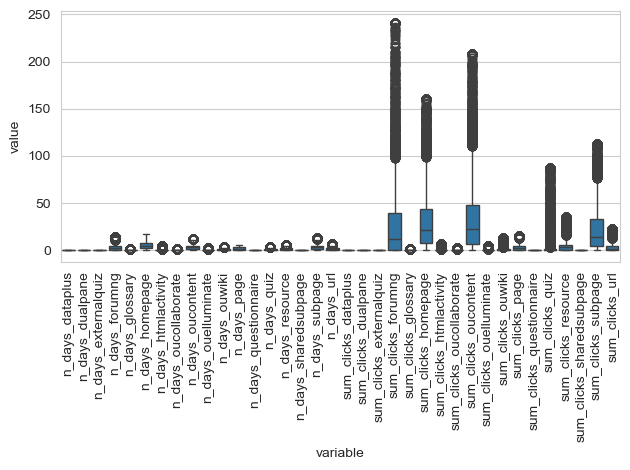

In [ ]:
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

cleaned_modules = {}

for mod, df_mod in module_dfs.items():
    df_mod.name = mod 
    print(f"Cleaning course {mod}...")

    df_cleaned, df_raw = clean_data(df_mod) 
    cleaned_modules[mod] = df_cleaned    


In [ ]:
#normalize
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def normalize_module_dfs(df_cleaned, decimals=4):

    categorical_cols = ['code_module', 'code_presentation', 'id_student', 'final_result']
    
    # Additional normalized categorical variables
    additional_norm_cols = ['highest_education', 'imd_band', 'age_band', 'gender','region','disability']
    
    normalized_dfs = {}

    for module, df in df_cleaned.items():
        df = df.copy()
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        
        continuous_cols = [col for col in numeric_cols if col not in categorical_cols]        
        continuous_cols = list(set(continuous_cols + additional_norm_cols))  # 确保合并

        # Min-Max Scaler
        scaler = MinMaxScaler()
        df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
        df[continuous_cols] = df[continuous_cols].round(decimals)

        normalized_dfs[module] = df

    return normalized_dfs

normalized_module_dfs = normalize_module_dfs(cleaned_modules)

import os
output_dir = "outputs/normalized_module_csvs"
os.makedirs(output_dir, exist_ok=True)

for module, df_norm in normalized_module_dfs.items():
    df_norm.to_csv(f"{output_dir}/{module}_normalized1_0.25.csv", index=False)


C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 20114 (\N{CJK UNIFIED IDEOGRAPH-4E92}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 24687 (\N{CJK UNIFIED IDEOGRAPH-606F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\619566078.py:26: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missi

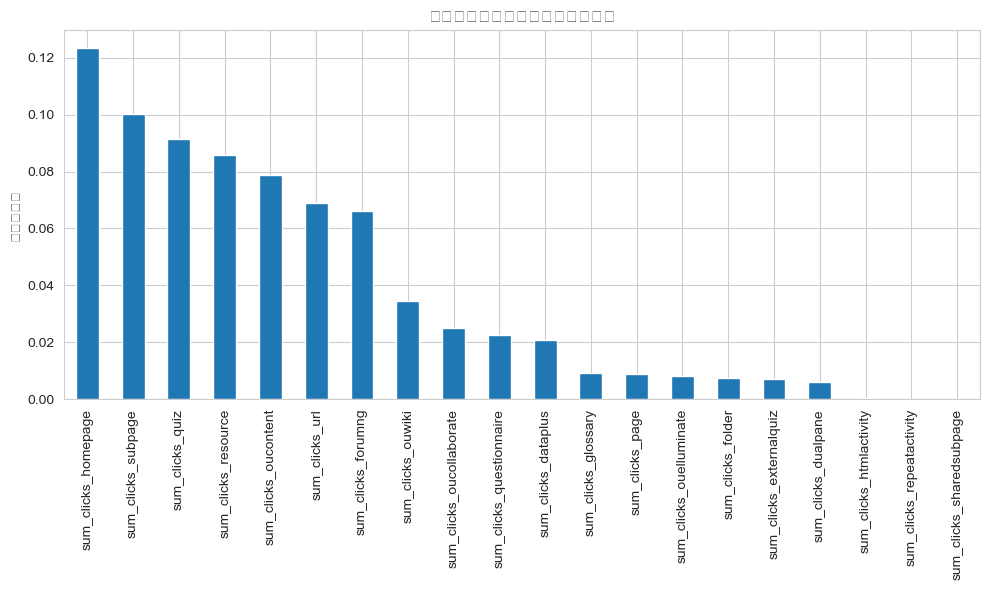

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

all_df = pd.concat(normalized_module_dfs.values(), ignore_index=True)

click_features = [col for col in all_df.columns if col.startswith("sum_clicks_")]

X = all_df[click_features].fillna(0) 
y = all_df["final_result"]    

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=click_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar')
plt.title("Mutual Information Scores between Click Behaviors and Final Performance")
plt.ylabel("Mutual Information Scores")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 20114 (\N{CJK UNIFIED IDEOGRAPH-4E92}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 24687 (\N{CJK UNIFIED IDEOGRAPH-606F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\1110148734.py:27: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9})

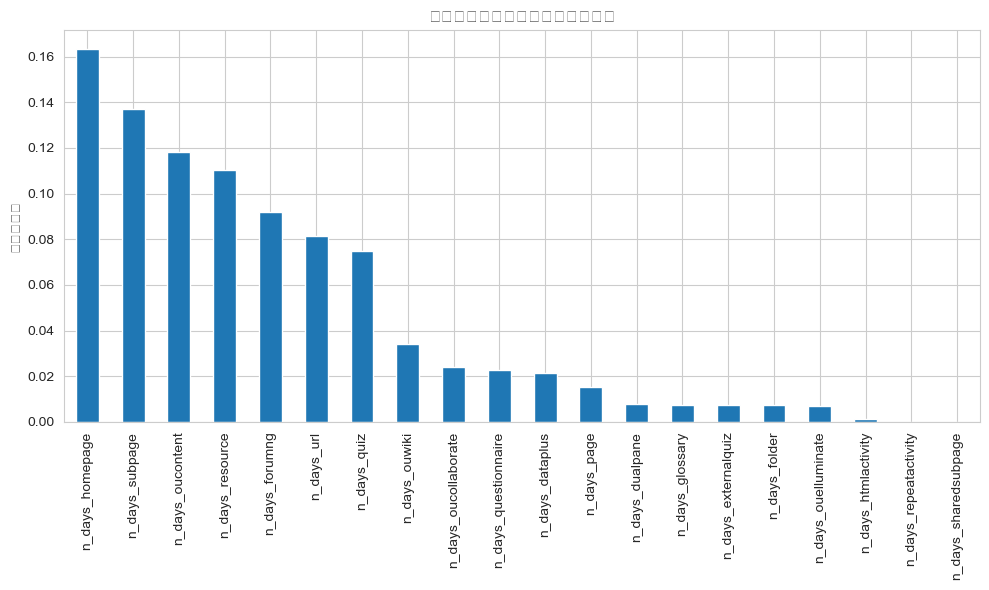

In [ ]:
#mutual information
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

all_df = pd.concat(normalized_module_dfs.values(), ignore_index=True)

click_features = [col for col in all_df.columns if col.startswith("n_days_")]

X = all_df[click_features].fillna(0)  
y = all_df["final_result"]          

mi_scores = mutual_info_classif(X, y, random_state=0)


mi_series = pd.Series(mi_scores, index=click_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar')
plt.title("Mutual Information Scores between Click Behaviors and Final Performance")
plt.ylabel("Mutual Information Scores")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import logging
import os
import numpy as np
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from pandas.api.types import CategoricalDtype

_LOG = logging.getLogger(__name__)

def vle_eda(df, base_wd):
  
    records = [] 
    prefixes = ['n_day', 'sum_clicks']
    vle_vars = ['total_n_days', 'total_sum_clicks'] + \
               list(compress(df.columns, df.columns.str.startswith(tuple(prefixes))))

    vle_vars.append('final_result')
    df2 = df[vle_vars]

    for col in df2.columns:
        if col in ['final_result', 'score']:
            continue

        col_avg = df2[col].mean()
        df2[col] = np.where(df2[col] > 0, 1, 0) 
        col_pct = df2[col].sum() / len(df2[col])

        record = {
            'vle_var': col,
            'average': col_avg,
            'pct_utilized': col_pct
        }
        records.append(record)

    vle_df = pd.DataFrame(records)
    os.makedirs(base_wd + "\\outputs\\dataframes", exist_ok=True)
    vle_df.to_csv(base_wd + f"\\outputs\\dataframes\\vle_df_rq1.csv", index=False)


def draw_histograms(df, variables, base_wd, subfolder):
    for i, var_name in enumerate(variables):
        plt.figure()
        df[var_name].hist(bins=10)
        plt.title(var_name + "Distribution")
        plt.savefig(base_wd + f'\\outputs\\plots\\{subfolder}\\histogram_{var_name}.png')


def draw_boxplots(df, variables, outcome, base_wd, subfolder):
    if pd.api.types.is_categorical_dtype(df[outcome]):
        order = df[outcome].cat.categories.tolist()
    else:
        order = sorted(df[outcome].unique())

    for var_name in variables:
        if var_name == outcome:
            continue
        plt.figure()
        sns.set_style("whitegrid")
        sns.boxplot(x=outcome, y=var_name, data=df, order=order, palette="Set2")
        
        plt.tight_layout()
        name = f'{outcome}_by_{var_name}'
        plt.savefig(base_wd + f'\\outputs\\plots\\{subfolder}\\' + name + '.png')


def draw_barplots(df, variables, base_wd, subfolder, group=False):
    plt.clf()

    for i, var_name in enumerate(variables):

        if group:
            if var_name == 'final_result':
                continue
            df_grp = pd.crosstab(index=df[var_name], columns=df['final_result'], normalize="index")
            df_grp = df_grp.reindex(columns=['Fail', 'Withdrawn', 'Pass', 'Distinction'])


            df_grp.plot(kind='bar', stacked=True, colormap='tab10')
            plt.legend(loc="upper left", ncol=4)
            plt.xlabel(var_name)
            plt.ylabel("Proportion")
            plt.title(f'{var_name} by final results')
            name = f'final_result_by_{var_name}'

        else:
            df[var_name].value_counts().plot(kind="bar")
            plt.title(var_name)
            name = f'barplot_{var_name}'

        plt.savefig(base_wd + f'\\outputs\\plots\\{subfolder}\\' + name + '.png')


def draw_corrplots(df, base_wd, subfolder):

    plt.clf()
    df = df.apply(pd.to_numeric, errors='coerce')
    matrix = df.corr()
    sns.heatmap(matrix, annot=True)
    plt.savefig(base_wd + f'\\outputs\\plots\\{subfolder}\\correlation_matrix.png')


def scatterplots(df, variables, outcome, base_wd, subfolder):

    for i, var_name in enumerate(variables):
        if var_name == outcome:
            continue

        plt.figure()
        pc = stats.pearsonr(df[var_name], df[outcome])[0]
        ax = sns.scatterplot(x=var_name, y=outcome, data=df)
        ax.set_title(f'{outcome} by {var_name} -- pearson coef: {pc}')
        ax.set_xlabel(var_name)
        ax.set_ylabel(outcome)
        name = f'{outcome}_by_{var_name}'
        plt.savefig(base_wd + f'\\outputs\\plots\\{subfolder}\\' + name + '.png')


def bivariate_eda(df, num_vars, cate_vars_short, base_wd, subfolder):

    outcome = 'final_result'
    num_vars.append('final_result')
    cate_vars_short.append('final_result')
    num_df = df.loc[:, df.columns.isin(num_vars)]
    cate_df = df.loc[:, df.columns.isin(cate_vars_short)]

    draw_corrplots(num_df, base_wd, subfolder)
    draw_barplots(cate_df, cate_df.columns, base_wd, subfolder, group=True)
    draw_boxplots(num_df, num_df.columns, outcome, base_wd, subfolder)


def univariate_eda(df, base_wd, subfolder):

    num_vars = ['num_of_prev_attempts', 'studied_credits', 'total_n_days',
                'total_sum_clicks']
    num_df = df.loc[:, df.columns.isin(num_vars)]
    draw_histograms(num_df, num_df.columns, base_wd, subfolder)

    cate_vars_short = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band',
                       'age_band', 'disability', 'final_result']
    cate_df = df.loc[:, df.columns.isin(cate_vars_short)]
    draw_barplots(cate_df, cate_df.columns, base_wd, subfolder)

    return num_vars, cate_vars_short


def eda(df):

    base_wd = os.path.normpath(os.getcwd())
    df = df.drop(columns=['id_student'])
    
    final_result_order = ['Fail', 'Withdrawn', 'Pass', 'Distinction']
    cat_type = CategoricalDtype(categories=final_result_order, ordered=True)
    df['final_result'] = df['final_result'].astype(cat_type)

    subfolder = 'RQ1_EDA'
    dir = 'outputs\\plots\\' + subfolder
    if not os.path.exists(dir):
        os.makedirs(dir)

    num_vars, cate_vars_short = univariate_eda(df, base_wd, subfolder)
    bivariate_eda(df, num_vars, cate_vars_short, base_wd, subfolder)
    vle_eda(df, base_wd)

C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\2996442566.py:59: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[outcome]):
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\2996442566.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome, y=var_name, data=df, order=order, palette="Set2")
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\2996442566.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=outcome, y=var_name, data=df, order=order, palette="Set2")
C:\Users\zh_ch\AppData\Local\Temp\ipykernel_19544\2996442566.py:32: SettingWithC

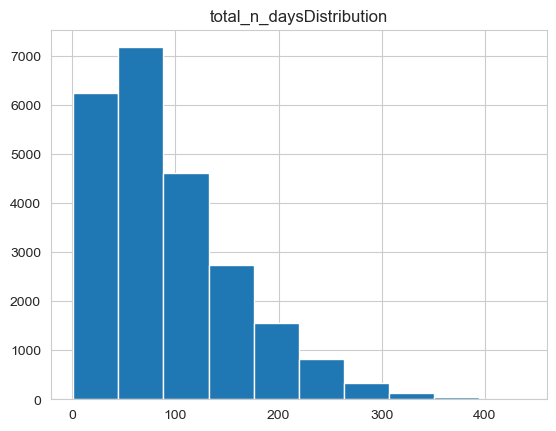

<Figure size 640x480 with 0 Axes>

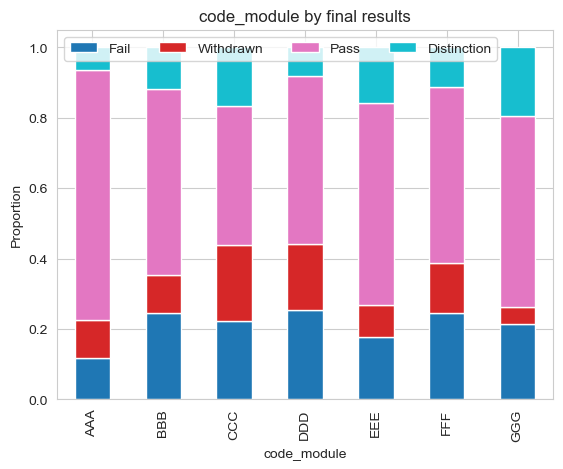

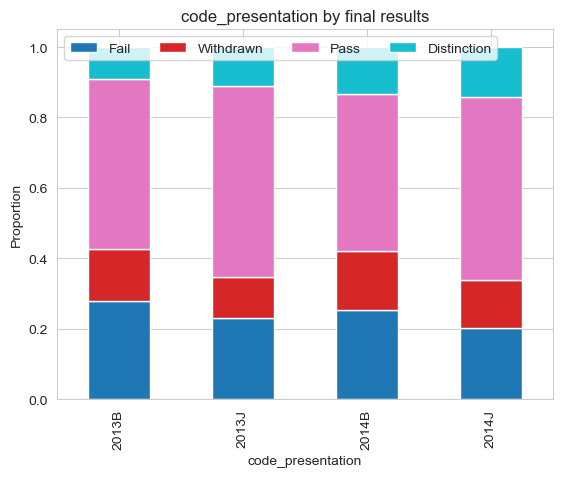

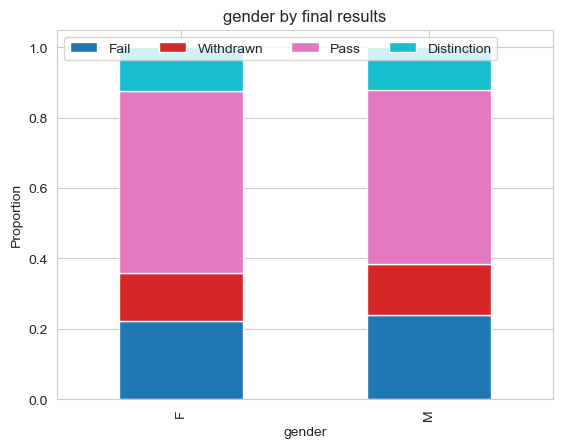

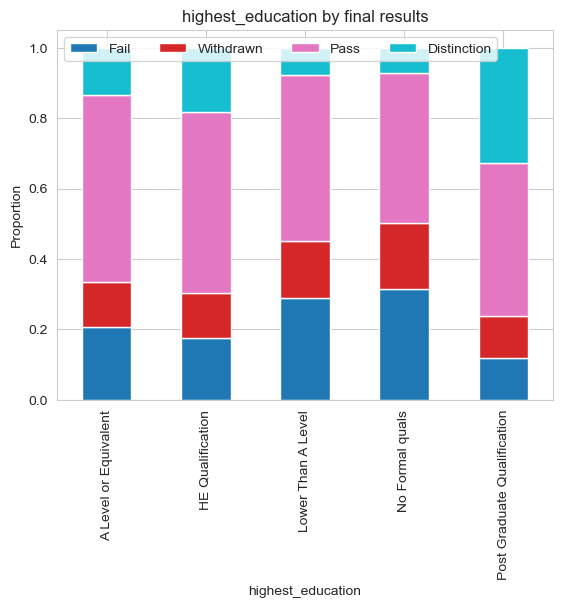

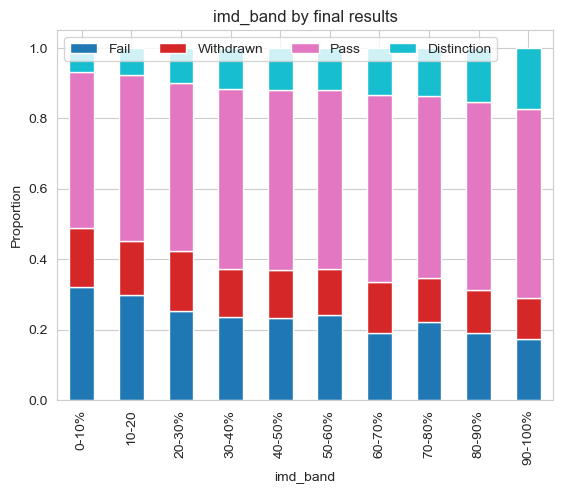

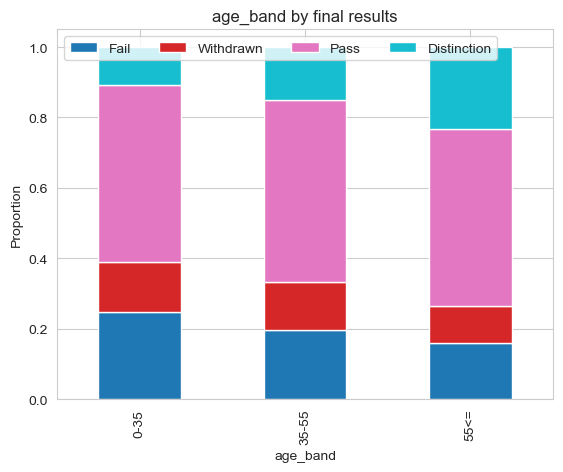

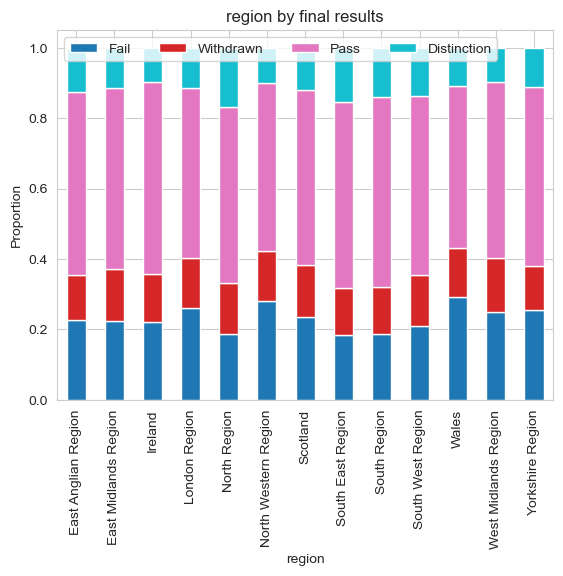

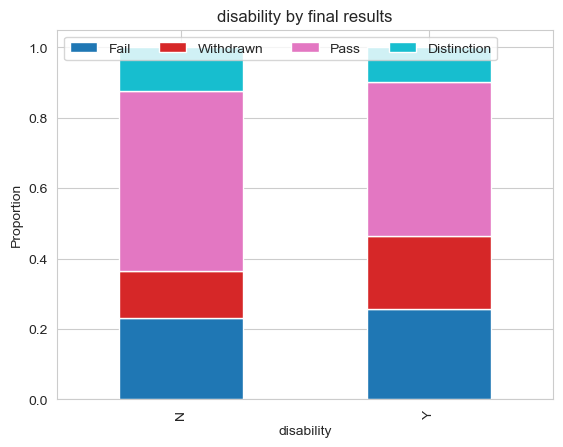

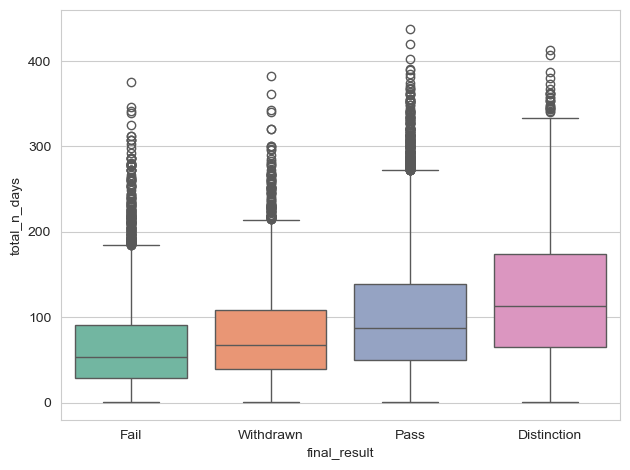

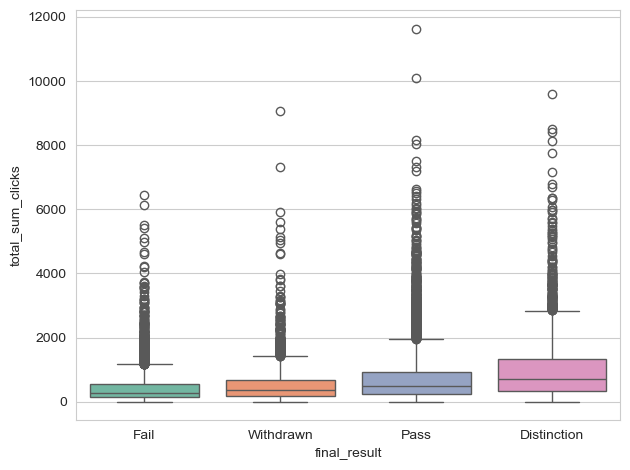

In [ ]:

eda(rq1_df1)
